Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved. SPDX-License-Identifier: Apache-2.0

# Ask the Graph
# Notebook 3: Query!

In this notebook, we query the data ingested in notebook 2. We query in several ways:

- Run SPARQL queries on the knowledge graph in Amazon Neptune database
- Run searches, using OpenSearch domain-specific language, of the search index/vector store in Amazon OpenSearch Service domain
- Run natural language queries! 

Here is our data model. This notebook prepares the unstructured sources (red boxes, upper third) and extracted facts (yellow boxes, middle third).

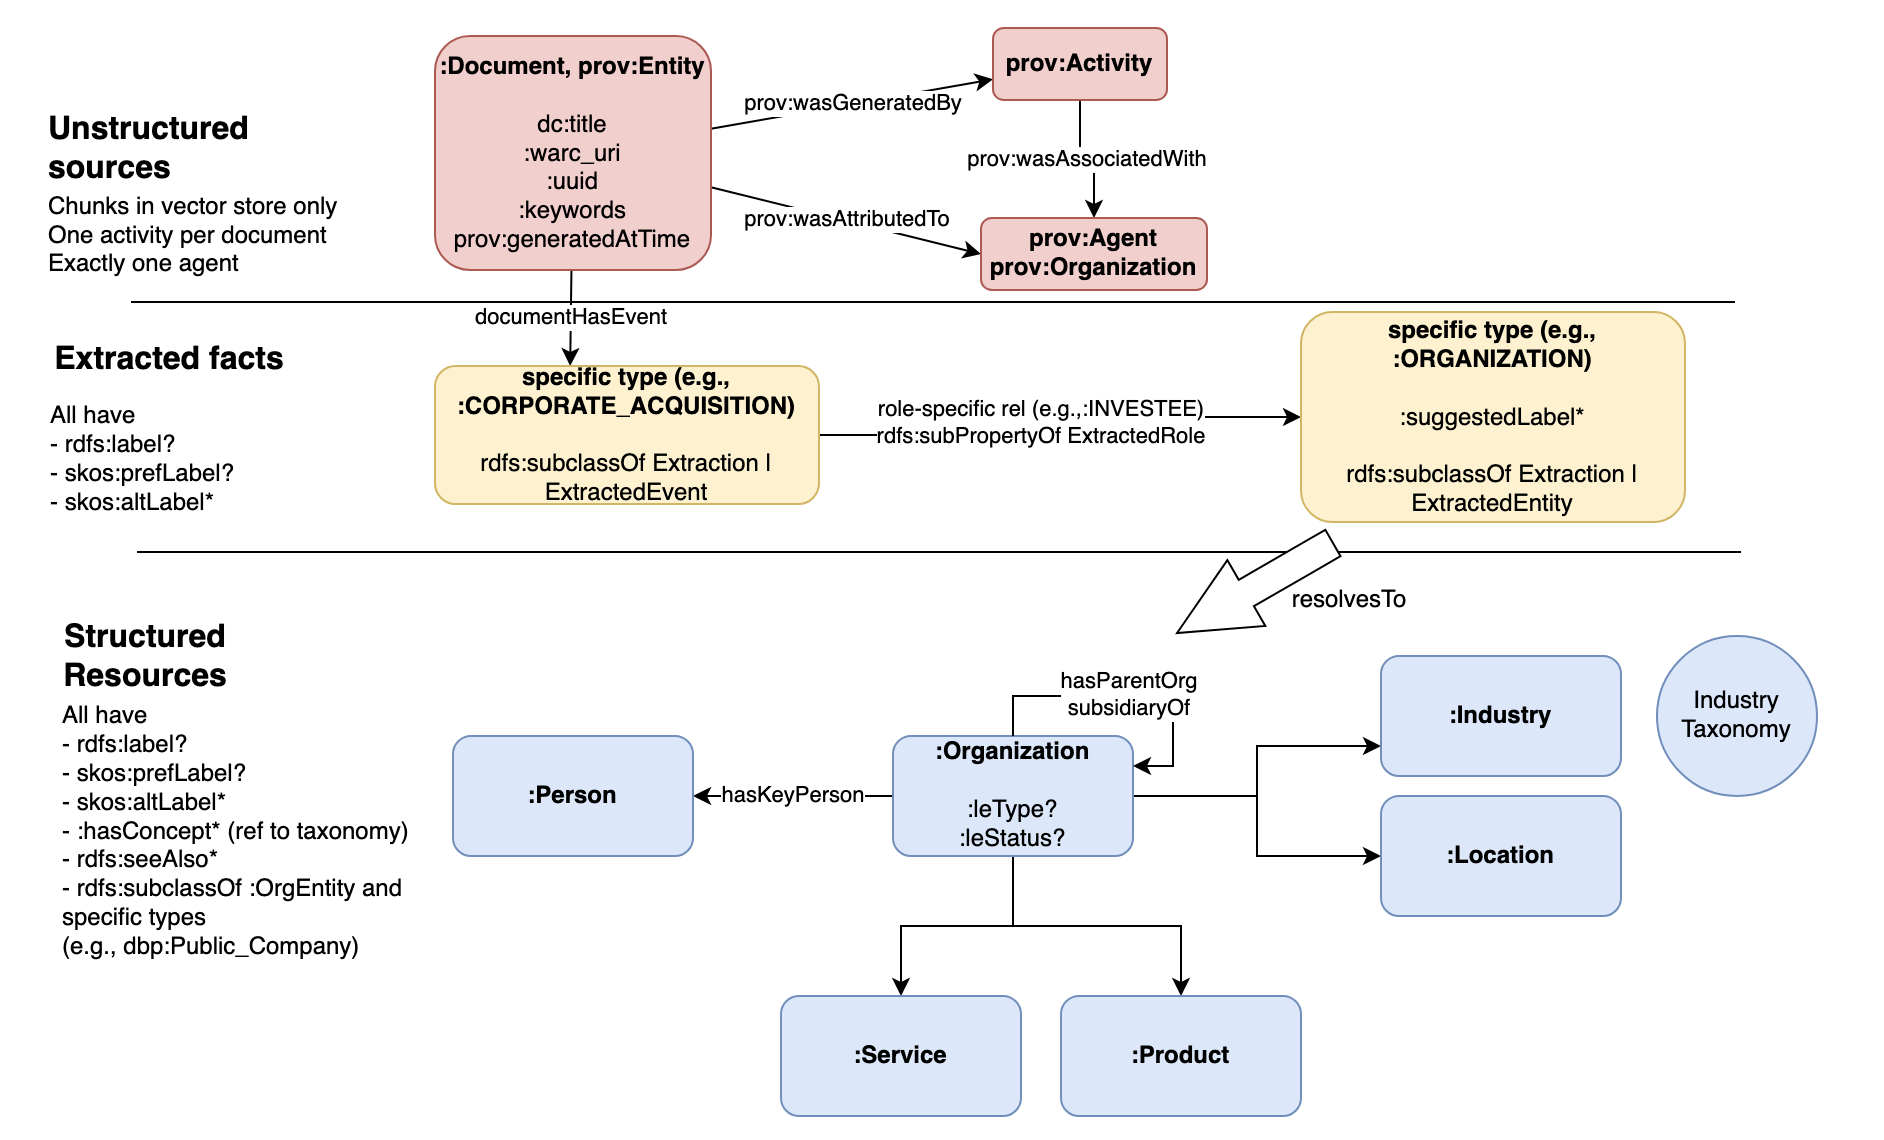

Here is how natural language queries work.

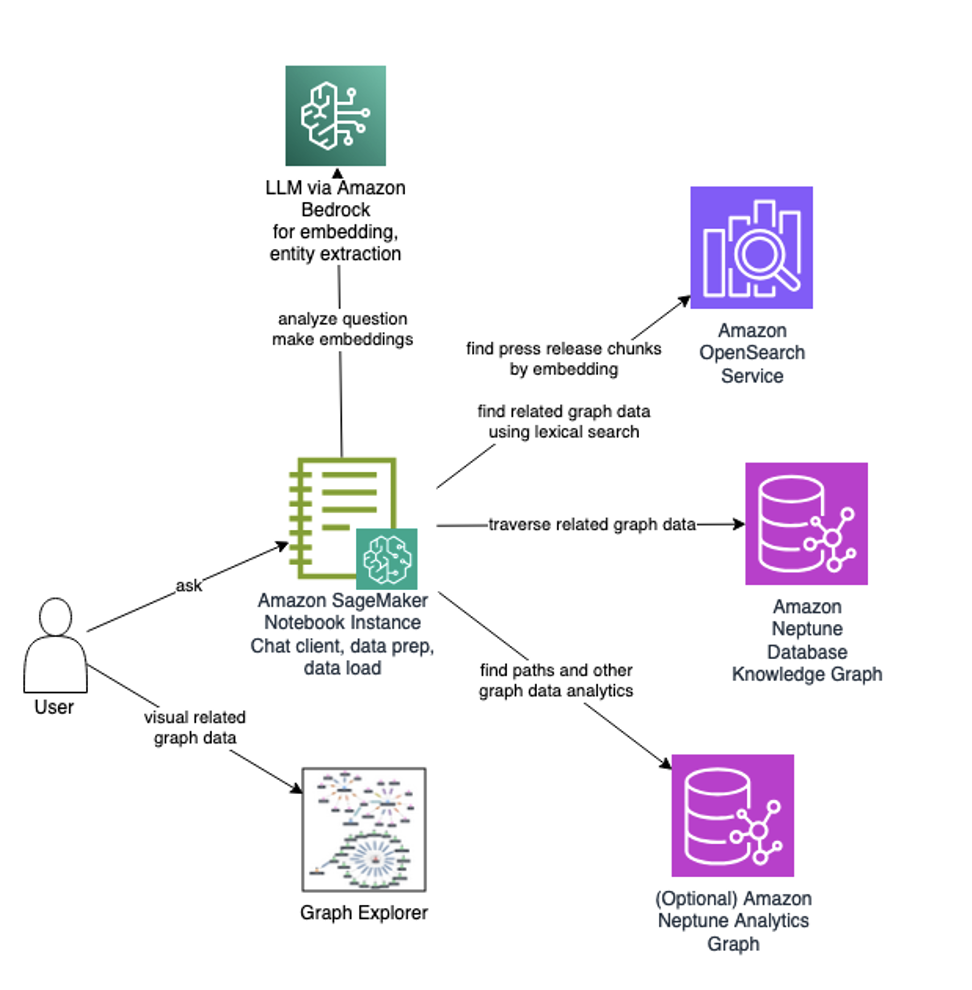

The notebook serves as a chat application, which accepts natural language questions from you, the user. We use large language models (LLMs) to extract important entities from the question, as well as to create a vector embedding of the question. We then search both the OpenSearch domain and the Neptune database for similar resources. We follow their relationships to arrive at the answer.

To run this notebook, we assume you have a Neptune cluster, an OpenSearch Service domain, an S3 staging bucket, full-text search setup to stream Neptune updates to OpenSearch. Additionally, the notebook instance must have S3, Bedrock, Neptune, and OpenSearch permissions, as well as connectivity to Neptune and OpenSearch. Refer to the README for setup instructions.


## Install a few dependencies


In [ ]:
!pip install -q opensearch-py

In [ ]:
!pip install python-dotenv

## Initialize

In [ ]:
import os
import boto3
import aos_helpers as aosh
import neptune_helpers as nh
import ai_helpers as aih
import query_helpers as qh
from botocore.config import Config
from dotenv import load_dotenv

session=boto3.Session()

# Load from .env file
load_dotenv()

# AOS connection
AOS_ENDPOINT_HOST=os.getenv("AOS_ENDPOINT_HOST")
aos_client = aosh.connect_aos(AOS_ENDPOINT_HOST)

# Neptune setup is more complex.
# This notebook must be able to connect to the Neptune cluster.
# If you use the optional Neptune Analytics query, it must be able to connect to the NA graph too.
# Will check for settings in .env and then in environment variables set by graph notebook setup.
# This function gets an ENV Var from graph notebook
def get_neptune_env(var: str) -> str:
    ret=os.getenv(var)
    if ret is None:
        return os.popen(f"source ~/.bashrc ; echo ${var}").read().split("\n")[0]

GRAPH_NOTEBOOK_HOST=get_neptune_env("GRAPH_NOTEBOOK_HOST") # ndb
GRAPH_NOTEBOOK_PORT=get_neptune_env("GRAPH_NOTEBOOK_PORT") # ndb
GRAPH_NOTEBOOK_AUTH_MODE=get_neptune_env("GRAPH_NOTEBOOK_AUTH_MODE") # ndb
AWS_REGION=get_neptune_env("AWS_REGION") # na and ndb
GRAPH_IDENTIFIER=os.getenv("GRAPH_IDENTIFIER") # for NA  

neptune_conn={
    nh.CONN_AWS_REGION : AWS_REGION,
    nh.CONN_USE_IAM_AUTH : GRAPH_NOTEBOOK_AUTH_MODE != "DEFAULT",
    nh.CONN_NEPTUNE_ENDPOINT: f"https://{GRAPH_NOTEBOOK_HOST}:{GRAPH_NOTEBOOK_PORT}/sparql",
    nh.CONN_GRAPH_IDENTIFIER: GRAPH_IDENTIFIER
}
print(neptune_conn)

na_client = session.client('neptune-graph')

# Bedrock and Comprehend setup
bedrock_client = session.client(service_name="bedrock-runtime")
comprehend_client = session.client(service_name="comprehend")

qh_client={
    qh.CONN_SESSION: session,
    qh.CONN_NEPTUNE: neptune_conn,
    qh.CONN_AOS: aos_client,
    qh.CONN_BEDROCK: bedrock_client,
    qh.CONN_COMPREHEND: comprehend_client,
    qh.CONN_NA: na_client
}


## Run full query

In [ ]:
questions=[
    "What are the connections between ticker AMZN and John Mackey?",
    "What do Amazon, Whole Foods, Rivian and Ring have in common",
    "Did Amazon buy Whole Foods or ACME",
    "Are there any press releases about lockjaw or epidemics or Leo Gehrig's Disease or the WHO?",
    "Does amazonn have fulfilllment centers near Chicago or New Yoork, and is the WHO or the NFL a customer",
    "Tell me about Ring or Jeff Bezos",
    "Does Amazon have a fulfillment center in Mississippi?",
    "Summary deals where FAANG acquired startups",
    "What activities does AWS have going on in San Francisco?",
    "Summarize the top trends in AWS",
    "Summary deals where Amazon was investor in startups"
    "Describe job retraining programs",
    "Which companies have a lot of products and services?",
    "Name some cloud companies"
]

question=questions[1]
print(question)

results=qh.answer_question(qh_client, question)

qh.render_results_json_file("test1.json", results)

# A RAG answer - LLM summarizes our results
qh.render_results_llm_summary(qh_client, 'testsummary1.txt', question, results)


## Search the graph
The graph meant to be really searchable. So let's search it in several ways. We brought these together in the answer_question() experiment above. Now we break that apart.

### Find resources by name in Neptune
Here I need to know the exact name, but it can be any of the preferred or alternate names in the *rich naming* scheme.


In [21]:
import neptune_helpers as nh

res=nh.find_resource_by_name(qh_client[qh.CONN_SESSION], qh_client[qh.CONN_NEPTUNE], "Amazon")
set(map(lambda r: r['s']['value'], res['results']['bindings']))
            
# to see full, dump res

{'http://example.org/orgdemo/ExtractedEntity/organization_amazon',
 'http://example.org/orgdemo/ExtractedEntity/organization_amazon.com',
 'http://example.org/orgdemo/ExtractedEntity/organization_amazon.com,_inc.',
 'http://example.org/orgdemo/ExtractedEntity/organization_amazon_future_engineer',
 'http://example.org/orgdemo/ExtractedEntity/organization_amazon_studios',
 'http://example.org/orgdemo/ExtractedEntity/organization_company',
 'http://example.org/orgdemo/ExtractedEntity/organization_employer',
 'http://example.org/orgdemo/ExtractedEntity/organization_prime',
 'http://example.org/orgdemo/ExtractedEntity/organization_we',
 'http://example.org/orgdemo/ExtractedEntity/stock_code_nasdaq:_amzn',
 'http://example.org/orgdemo/ExtractedEntity/stock_code_nasdaq:amzn'}

### Describe
Find details about a resource in Neptune, including its neighbors. Behind the scenes, this is not a SPARQL DESCRIBE but something more ambitious: a SELECT that explores a bit and sees where this resource fits into RYB.

In [56]:
import neptune_helpers as nh

def pv(r, p): 
    return r[p]['value'] if p in r else "-"

def print_desc_prop(rp):
    print(f"{pv(rp, 'p')} [{pv(rp, 'pLabels')}] ={pv(rp, 'o')} ({pv(rp, 'direction')})")

def print_desc(uri):
    res=nh.make_select_table(nh.describe(qh_client[qh.CONN_SESSION], qh_client[qh.CONN_NEPTUNE], uri, describe_limit=100))
    if len(res) > 0:
        r0=res[0]
        print(f"""
URI: {pv(r0, 'uri')}
Classification: {pv(r0, 'cat')}
Types: {pv(r0, 'types')} {pv(r0, 'typeLabels')} {pv(r0, 'typeSuperClasses')}
URI super (if class):  {pv(r0, 'uriSuperClasses')}
URI super (if prop):  {pv(r0, 'uriSuperProperties')}
        """)
        for r in res: print_desc_prop(r)
    # to see full, dump res  

# red: document
uri="http://example.org/orgdemo/Document/5c284c23-dbee-4e70-8024-a04be19a6e38"
print_desc(uri)

# yellow: event
uri="http://example.org/orgdemo/ExtractedEvent/5c284c23-dbee-4e70-8024-a04be19a6e38_investment_general_invest1360"
print_desc(uri)

# yellow: entity
uri="http://example.org/orgdemo/ExtractedEntity/organization_amazon"
print_desc(uri)

# blue: resource
uri="http://dbpedia.org/resource/Epic_Games"
print_desc(uri)
uri="http://dbpedia.org/resource/Whole_Foods_Market"
print_desc(uri)

# blue: concept
uri="http://example.org/industry/BigTech"
print_desc(uri)
uri="http://example.org/industry/CloudComputing"
print_desc(uri)

# classes and properties
uri="http://example.org/orgdemo/Organization"
print_desc(uri)
uri="http://example.org/orgdemo/hasParentOrg"
print_desc(uri)
uri="http://example.org/orgdemo/xev/CORPORATE_ACQUISITION"
print_desc(uri)
uri="http://example.org/orgdemo/xent/ORGANIZATION"
print_desc(uri)
uri="http://example.org/orgdemo/xrole/INVESTMENT_PLACE"
print_desc(uri)



URI: http://example.org/orgdemo/Document/5c284c23-dbee-4e70-8024-a04be19a6e38
Classification: document
Types: http://www.w3.org/ns/prov#Entity|http://example.org/orgdemo/Document unstructured document 
URI super (if class):  
URI super (if prop):  
        
http://example.org/orgdemo/documentHasEvent [documentHasEvent] =http://example.org/orgdemo/ExtractedEvent/5c284c23-dbee-4e70-8024-a04be19a6e38_employment_change_created129 (out)
http://example.org/orgdemo/documentHasEvent [documentHasEvent] =http://example.org/orgdemo/ExtractedEvent/5c284c23-dbee-4e70-8024-a04be19a6e38_employment_change_double75 (out)
http://example.org/orgdemo/documentHasEvent [documentHasEvent] =http://example.org/orgdemo/ExtractedEvent/5c284c23-dbee-4e70-8024-a04be19a6e38_employment_change_employs270 (out)
http://example.org/orgdemo/documentHasEvent [documentHasEvent] =http://example.org/orgdemo/ExtractedEvent/5c284c23-dbee-4e70-8024-a04be19a6e38_employment_change_hires3983 (out)
http://example.org/orgdemo/docum

In [23]:
import aos_helpers as aosh

res=aosh.find_entities_by_label(qh_client[qh.CONN_AOS], ["ammazon", "whool food"])
set(map(lambda r: r['_source']['entity_id'], res['hits']['hits']))

# to see full, dump res               

{'http://dbpedia.org/resource/Amazon_(company)',
 'http://example.org/orgdemo/ExtractedEntity/organization_amazon',
 'http://example.org/orgdemo/ExtractedEntity/organization_amazon_future_engineer',
 'http://example.org/orgdemo/ExtractedEntity/organization_amazon_handmade',
 'http://example.org/orgdemo/ExtractedEntity/organization_amazon_literary_partnership',
 'http://example.org/orgdemo/ExtractedEntity/organization_amazon_publishing',
 'http://example.org/orgdemo/ExtractedEntity/organization_amazon_studios',
 'http://example.org/orgdemo/ExtractedEntity/organization_food_bank',
 'http://example.org/orgdemo/ExtractedEntity/organization_three_square_food_bank',
 'http://example.org/orgdemo/ExtractedEntity/organization_whole_foods_market'}

### Find chunks in OpenSearch Service
It's a semantic search using vector embeddings.

In [24]:
import ai_helpers as aih
import aos_helpers as aosh

question="Amazon buys Ring or Rivian"
search_vector=aih.make_embedding(qh_client[qh.CONN_BEDROCK], question)
res=aosh.find_chunks(qh_client[qh.CONN_AOS], search_vector)
list(map(lambda r: [r['_score'],r['_source']['title'],r['_source']['chunk_index'],r['_source']['date'],r['_source']['graph_doc_uri']], res['hits']['hits']))

# to see full, dump res 


[[0.7325257,
  'Amazon and Ring Close Acquisition—Now Working Together to Empower Neighbors with Affordable Ways to Monitor their Homes and Reduce Crime in Neighborhoods',
  0,
  '2020-02-29T13:11:24Z',
  'http://example.org/orgdemo/Document/d0b964d4-0170-46b2-8b13-8796d5fd2aa4'],
 [0.68908095,
  'Amazon and Ring Close Acquisition—Now Working Together to Empower Neighbors with Affordable Ways to Monitor their Homes and Reduce Crime in Neighborhoods',
  1,
  '2020-02-29T13:11:24Z',
  'http://example.org/orgdemo/Document/d0b964d4-0170-46b2-8b13-8796d5fd2aa4'],
 [0.6424332,
  'Amazon Has Enabled Hundreds of Small Businesses and Created Over 100,000 Jobs Across Its Last Mile Delivery Network',
  1,
  '2020-03-30T19:55:27Z',
  'http://example.org/orgdemo/Document/bea8bcc1-c9a9-489f-af51-70956152ad64'],
 [0.64112926,
  'Amazon Opens Search for Amazon HQ2 – A Second Headquarters City in North America',
  1,
  '2019-08-25T07:42:39Z',
  'http://example.org/orgdemo/Document/a7373061-008b-4ec8-97

### Analyze a natural language question with help from our ontology and taxonomy
This is not actually a query, but it shows how an LLM can use ontology and taxonomy to guide its answer. 

We ask a question to the LLM. *Did Amazon buy Whole Foods or ACME*

The LLM's prompt includes instructions to consider our RYB ontology and industry taxonomy. 

Notice the LLM response finds that there is a *buy* predicate with well-known URI *http://example.org/orgdemo/xev/CORPORATE_ACQUISITION*. That URI is not public and not in the LLM's corpus. It appears in our ontology. 

In [25]:
import ai_helpers as aih

question="Did Amazon buy Whole Foods or ACME"
aih.analyze_question(qh_client[qh.CONN_BEDROCK], question)


{'entities': {'Amazon': {'alternateEntityNames': ['Amazon.com'],
   'wellKnownURIs': ['http://dbpedia.org/resource/Amazon_(company)'],
   'type': 'Organization'},
  'Whole Foods': {'alternateEntityNames': ['Whole Foods Market'],
   'wellKnownURIs': ['http://dbpedia.org/resource/Whole_Foods_Market'],
   'type': 'Organization'},
  'ACME': {'alternateEntityNames': [],
   'wellKnownURIs': [],
   'type': 'Organization'}},
 'types': {},
 'predicates': {'buy': {'alternateNames': ['acquire', 'purchase'],
   'wellKnownURIs': ['http://example.org/orgdemo/xev/CORPORATE_ACQUISITION']}},
 'intent': [['connect', 'Amazon', 'Whole Foods', 'buy'],
  ['connect', 'Amazon', 'ACME', 'buy']]}

### Rich-naming-guided entity resolution
For a given term, see if there are entities like it in the graph. Do this by asking the LLM for well-known alternate names and URIs of the term. Then see if there are resources in the graph with the same URI.


In [27]:
import ai_helpers as aih
import neptune_helpers as nh

# 1 Resolve the term to alternate names. LLM brings back well-known alternatives.
term="Whole foods"
res=aih.resolve_entity(qh_client[qh.CONN_BEDROCK], term)

# 2 If it's a URI, see if we found it in Neptune
def is_uri(uri):
    return uri.startswith("http://") or uri.startswith("https://")

for r in res:
    print(f"Match {r}")
    if is_uri(r):
        sparql_query=f"""
select distinct ?uri where {{
   BIND (<{r}> as ?uri).
   ?uri ?p ?o .
}} LIMIT 1
        """
        nres=nh.execute_sparql(qh_client[qh.CONN_SESSION], qh_client[qh.CONN_NEPTUNE], sparql_query)
        if len(nres['results']['bindings']) > 0:
            print("\t****found")


Match Whole Foods Market
Match Whole Foods
Match WFM
Match http://dbpedia.org/resource/Whole_Foods_Market
	****found
Match Whole Foods Market Inc.
Match Whole Foods grocery store
Match Whole Foods supermarket
Match Whole Foods organic grocery chain
Match Amazon's Whole Foods
Match https://www.wholefoodsmarket.com/


### Use Neptune Analytics to draw connections


In [76]:
import neptune_helpers as nh

def print_path(p):
    segs=p['path']
    pr_segs=""
    for s in segs:
        if s['~entityType'] == 'node':
            pr_segs += f"\n{s['~id']} ({s['~labels']})"
        else:
            pr_segs += f"\n\t{s['~type']}"
    print(pr_segs)

uris1=["http://example.org/industry/BigTech"]
uris2=["http://dbpedia.org/resource/James_D._Taiclet"]

res=nh.connect_resources(qh_client[qh.CONN_NA], qh_client[qh.CONN_NEPTUNE], uris1, uris2) 
for p in res:
    print_path(p)



<http://example.org/industry/BigTech> (['<http://www.w3.org/2004/02/skos/core#Concept>'])
	<http://example.org/orgdemo/hasConcept>
<http://dbpedia.org/resource/Amazon_(company)> (['<http://dbpedia.org/resource/Public_company>', '<http://example.org/orgdemo/Organization>'])
	<http://example.org/orgdemo/leType>
<http://dbpedia.org/resource/Public_company> ([])
	<http://example.org/orgdemo/leType>
<http://dbpedia.org/resource/Lockheed_Martin> (['<http://example.org/orgdemo/Organization>', '<http://dbpedia.org/resource/Public_company>'])
	<http://example.org/orgdemo/hasKeyPerson>
<http://dbpedia.org/resource/James_D._Taiclet> (['<http://example.org/orgdemo/Person>'])
